# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.


Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов:
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
- минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
- сообщение: 3 рубля; 
- 1 Гб интернет-трафика: 200 рублей.

### Тариф "Ультра"
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
- минута разговора: 1 рубль; 
- сообщение: 1 рубль; 
- 1 Гб интернет-трафика: 150 рублей.

** Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. **

### Описание данных
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Изучение данных и предоработка

Проект по изучению данных мобильного оператра "Мегалайн". Импортируем библиотеки, импортируем датасеты, смотрим на полученные фреймы:

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Нужно проверить все данные, пропуски, дубликаты, форматы данных. Начнем по порядку, с данных по вызовам:

In [4]:
# ищем дубликаты:
print(calls.duplicated().sum())

# ищем пропуски:
print(calls.info())

# смотрим на таблицу:
calls.head()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Пропусков и дубликатов нет, но необходимо перевести тип столбца call_date к datetime, а так же округлить минуты до целых значний:

In [5]:
# меняем формат даты:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# округляем минуты:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


Следующий набор данных про интернет:

In [6]:
# ищем дубликаты:
print(internet.duplicated().sum())

# ищем пропуски:
print(internet.info())

# смотрим на таблицу:
internet.head()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Дубликатов и пропусков нет. Но снова нужно привести солбец session_date к datetime. Так же есть странный столбец Unnamed: 0. Судя по первым пяти строкам таблицы - это дубликация индекса.

In [7]:
# приводим нужный формат даты:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# поверяем странный столбец:
internet.columns = ['Unnamed', 'id', 'mb_used', 'session_date', 'user_id']
print(len(internet['Unnamed'].unique()))

internet.head()


149396


,Unnamed,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Тип даты изменили. Подозрительная колонка действительно дублирует индексы, так как количство уникальных значений соответствует количеству строк. Она нам не нужна, думаю стоит её удалить.

In [8]:
internet = internet.drop('Unnamed', 1)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Изучим данные с сообщениями - messages:

In [9]:
# ищем дубликаты:
print(messages.duplicated().sum())

# ищем пропуски:
print(messages.info())

# смотрим на таблицу:
messages.head()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Дублкатов и пропусков нет. Но снова нужно помеять формат даты:

In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Проверяем набор данных с данными о тарифах - tariffs:

In [11]:
# ищем дубликаты:
print(tariffs.duplicated().sum())

# ищем пропуски:
print(tariffs.info())

# смотрим на таблицу:
tariffs.head()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Все в порядке. Смотрим на данные о пользователях - users:

In [12]:
# ищем дубликаты:
print(users.duplicated().sum())

# ищем пропуски:
print(users.info())

# смотрим на таблицу:
users.head()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Дубликатов нет, есть пропуски в строке churn_date. В описании к данным это указывает на то, что абонент еще пользуется тарифом,  пропущеные значения не трогаем.

## Подсчет данных по месяцам

Необходимо посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Добавим в каждый из набор данных столбец с месяцем. Потом создадим один датафрейм с необходимыми данными. 

In [13]:
# Создадим столбцы с номером месяца:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month


In [14]:
# сгруппируем и посчитаем данные по пользователю и месяцу:
num_of_calls = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])
num_of_messages = messages.groupby(['user_id', 'month'])['id'].count()
num_of_internet = internet.groupby(['user_id', 'month']).sum()['mb_used']

In [15]:
# создадим общий датафрейм:
df = num_of_calls.join([num_of_messages, num_of_internet], how='outer')
df = df.reset_index()
df.columns = ['user_id', 'month', 'count_calls', 'sum_calls', 'count_messages', 'sum_mb_used']
df.head()

,user_id,month,count_calls,sum_calls,count_messages,sum_mb_used
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91


Нужно преобразовать мегабайты в гигабайты и округлить в бОльшую сторону, так как оператор округляет гигабайты именно в бОльшую сторону:

In [16]:
df['sum_mb_used'] = df['sum_mb_used']/1024
df['sum_mb_used'] = np.ceil(df['sum_mb_used'])
df = df.rename(columns={'sum_mb_used':'sum_gb_used'})
df.head()

,user_id,month,count_calls,sum_calls,count_messages,sum_gb_used
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0


Добавим тариф к нашей таблице

In [17]:
# добавляем тариф
df = df.merge(users[['user_id','tariff']], on = 'user_id')
df.head()

,user_id,month,count_calls,sum_calls,count_messages,sum_gb_used,tariff
0,1000,5,22.0,159.0,22.0,3.0,ultra
1,1000,6,43.0,172.0,60.0,23.0,ultra
2,1000,7,47.0,340.0,75.0,14.0,ultra
3,1000,8,52.0,408.0,81.0,14.0,ultra
4,1000,9,58.0,466.0,57.0,15.0,ultra


Поскольку нужно будет сравнивать данные по городам, добавим в таблицу данные о городе абонента:

In [18]:
# добавляем город
df = df.merge(users[['user_id','city']], on = 'user_id')
df.head()

,user_id,month,count_calls,sum_calls,count_messages,sum_gb_used,tariff,city
0,1000,5,22.0,159.0,22.0,3.0,ultra,Краснодар
1,1000,6,43.0,172.0,60.0,23.0,ultra,Краснодар
2,1000,7,47.0,340.0,75.0,14.0,ultra,Краснодар
3,1000,8,52.0,408.0,81.0,14.0,ultra,Краснодар
4,1000,9,58.0,466.0,57.0,15.0,ultra,Краснодар


Готово. Теперь нам нужно посчитать выручку с каждого абонента. Напишем для этого функцию, и применим её к датафрейму. 

In [19]:
# общая функция для добавления столбца с абонентской платой:
def get_income(row):
    
    # локальная функция, считающая минуты, гигабайты и смс,
    # израсходованные сверх тарифного пакета:
    def get_over(dict_of_param):
        local_over_min = 0
        local_over_sms = 0
        local_over_gb = 0
        if row['sum_calls'] > dict_of_param['sum_calls']: 
            local_over_min = row['sum_calls'] - dict_of_param['sum_calls']
        if row['count_messages'] > dict_of_param['count_messages']:
            local_over_sms = row['count_messages'] - dict_of_param['count_messages']
        if row['sum_gb_used'] > dict_of_param['sum_gb_used']:
            local_over_gb = (row['sum_gb_used'] - dict_of_param['sum_gb_used'])
        return local_over_min, local_over_sms, local_over_gb   
    
    ultra_param = {
        'sum_calls':3000,
        'count_messages': 1000,
        'sum_gb_used': 30
    }
    smart_param = {
        'sum_calls':500,
        'count_messages': 50,
        'sum_gb_used': 15
    }
            
    if row['tariff'] == 'ultra':
        income = 1950
        over_min, over_sms, over_gb = get_over(ultra_param)
        income += over_min + over_sms + over_gb * 150     
    elif row['tariff'] == 'smart':
        income = 550
        over_min, over_sms, over_gb = get_over(smart_param)
        income += 3 * over_min + 3* over_sms + over_gb * 200 
    return income
df['income'] = df.apply(get_income, axis=1)
df

,user_id,month,count_calls,sum_calls,count_messages,sum_gb_used,tariff,city,income
0,1000,5,22.0,159.0,22.0,3.0,ultra,Краснодар,1950.0
1,1000,6,43.0,172.0,60.0,23.0,ultra,Краснодар,1950.0
2,1000,7,47.0,340.0,75.0,14.0,ultra,Краснодар,1950.0
3,1000,8,52.0,408.0,81.0,14.0,ultra,Краснодар,1950.0
4,1000,9,58.0,466.0,57.0,15.0,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,42.0,21.0,smart,Владикавказ,1750.0
3210,1499,9,9.0,70.0,11.0,2.0,smart,Пермь,550.0
3211,1499,10,68.0,449.0,48.0,18.0,smart,Пермь,1150.0
3212,1499,11,74.0,612.0,59.0,18.0,smart,Пермь,1513.0


В ходе проверки и предоработки данных обнаружили, что пропусков почти нет. Есть только там, где абоненты еще пользуются тарифом, поэтому дата окончания  использования тарифа не указана. 

Привели все типы дат к типу datetime, время в минутах округлили в большую сторону, округление гигабайт сделали после группировки по месяцам, так как оператор округляет данные за месяц. Округление на этапе чтения данных приведет к округлению каждой сессии, что сильно исказит данные.  Также избавились от ненужного столбца. 

Сгруппировали нужные нам данные и объеденили в один датафрейм, можно приступать к анализу. 

## Анализ данных

Нам необходимо описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Посчитаем среднее количество, дисперсию и стандартное отклонение в сводной таблице. 

In [20]:
df.pivot_table(index = 'tariff', values = ['count_calls', 'sum_calls', 'count_messages', 'sum_gb_used', 'income'],
                            aggfunc = ['mean', 'var', 'std'])

mean                                                      \
       count_calls count_messages       income   sum_calls sum_gb_used   
tariff                                                                   
smart    58.621233      38.716441  1289.973531  419.062978   16.336176   
ultra    76.016824      61.161006  2070.152284  545.451104   19.694359   

                var                                                          \
        count_calls count_messages         income     sum_calls sum_gb_used   
tariff                                                                        
smart    665.438829     717.594201  669785.708006  35844.189551   32.923756   
ultra   1798.043927    2109.659183  141516.745079  94203.418396   94.146734   

               std                                                     
       count_calls count_messages      income   sum_calls sum_gb_used  
tariff                                                                 
smart    25.796101      26.787949  818.404367  189.325618    5.737923  
ultra    42.403348      45.931026  376.187114  306.925754    9.702924

Исходя из полученных данных, можно сделать вывод, что пользователи тарифа ultra больше отправляют sms, больше звонят - как в количественном отношении, так и в продолжительности вызова и больше поользуются интернетом. Средний доход от тарифа samart намного ниже, чем у тарифа ultra. Мне кажется немного странным полученные средние данные, которые пользователи тратят на мобильную свзяь, на мой взгляд они выше средних значний на сегодняшний день. Проверим экстремальные значения по израсходованным минутам, гигабайтам и sms.  

In [21]:
print(df['sum_calls'].max())
print(df['count_messages'].max())
print(df['sum_gb_used'].max())

1673.0
224.0
49.0


Действительно не мало. Построим гистограммы для описания распределения. 

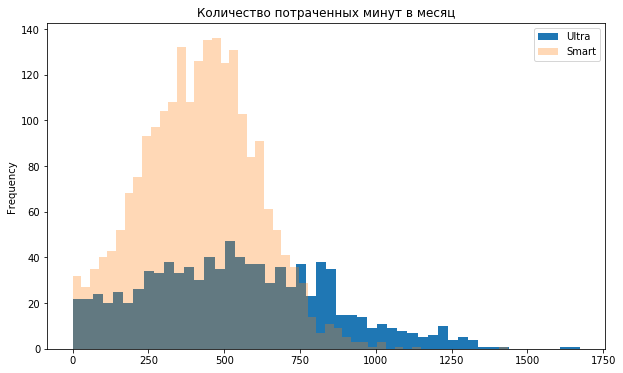

In [32]:
df[df['tariff'] == 'ultra']['sum_calls'].plot(kind='hist', bins=50, figsize=(10,6), alpha=1, label = 'Ultra')
df[df['tariff'] == 'smart']['sum_calls'].plot(kind='hist', bins=50, figsize=(10,6), alpha=0.3, label = 'Smart')
plt.title('Количество потраченных минут в месяц')
plt.legend()

Видим что продолжительность звонков на тарифе ultra больше, чем на тарифе smart. Зато на тарифе smart больше людей разговаривают от 300 до 600 минут в месяц. 

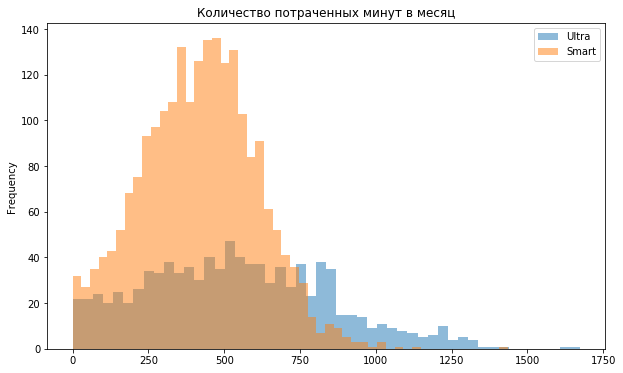

In [23]:
# код ревьюера
df[df['tariff'] == 'ultra']['sum_calls'].plot(kind='hist', bins=50, figsize=(10,6), alpha=0.5, label = 'Ultra')
df[df['tariff'] == 'smart']['sum_calls'].plot(kind='hist', bins=50, figsize=(10,6), alpha=0.5, label = 'Smart')
plt.title('Количество потраченных минут в месяц')
plt.legend();

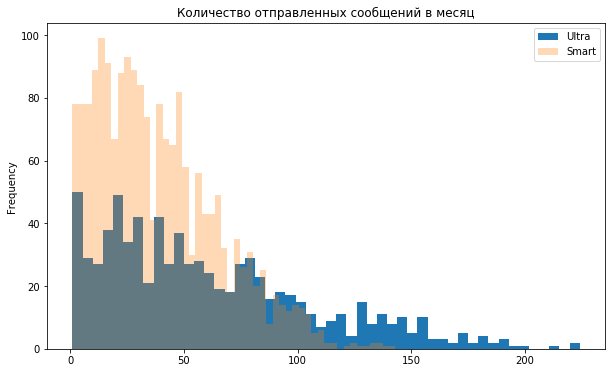

In [31]:
df[df['tariff'] == 'ultra']['count_messages'].plot(kind='hist', bins=50, figsize=(10,6), alpha=1, label = 'Ultra')
df[df['tariff'] == 'smart']['count_messages'].plot(kind='hist', bins=50, figsize=(10,6), alpha=0.3, label = 'Smart')
plt.title('Количество отправленных сообщений в месяц')
plt.legend()

На тарифе ultra средний пользователь сообщений отпрвляет больше, но в тарифе smart больше человек отправляет до 80 сообщений в месяц.  

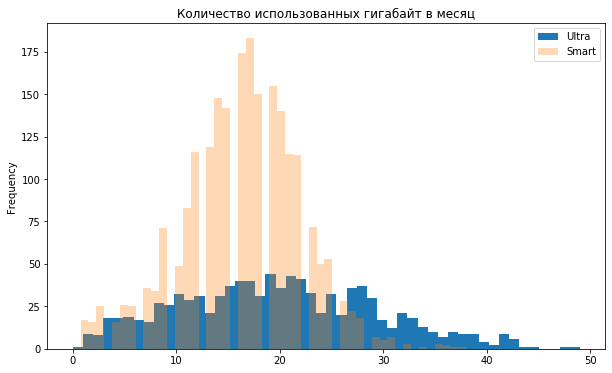

In [30]:
df[df['tariff'] == 'ultra']['sum_gb_used'].plot(kind='hist', bins=50, figsize=(10,6), alpha=1, label = 'Ultra')
df[df['tariff'] == 'smart']['sum_gb_used'].plot(kind='hist', bins=50, figsize=(10,6), alpha=0.3, label = 'Smart')
plt.title('Количество использованных гигабайт в месяц')
plt.legend()

И снова в тарифе ultra лидеры в использовании интернет-траффика. Использовавших более 28 ГБ траффика больше в трифе ultra, но пользователей потртивших до 25 ГБ больше с тарифом smart. Для общего вывода посмотрим количество абонентов с разными тарифами:

In [26]:
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

Общий вывод по использованию двух тарифов. Количество пользователей тарифа smart более чем в два раза больше, и это не удивительно, ведь его абонентская плата почти в четыре раза ниже! Однако судя по графикам абоненты тарифа smart чаще используют дополнительные, платные минуты, в то время как пользователи тарифа ultra всегда укладываются в свой лимит, не смотря на то, что часто их разговоры за месяц сильно превышают разговоры абонентов тарифа smart. 

Аналогичная ситуация с сообщениями, абоненты тарифа smart часто использут платные sms, в то время как абоненты ultra всегда укладываются в 3000 заложенных в тарифе сообщений.

А вот в траффик интернета никто не укладывается. Дополнительными "гигами" пользуются все. Но чаще, конечно, пользователи тарифа smart. 


## Проверка гипотез

Необходимо проверить две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


Итак первая гипотеза о равенстве выручки среди тарифов "Ультра" и "Смарт".
- Нулевая гипотеза: выручка пользователей тарифов "Ультра" и "Смарт" не различаются
- Альтернативная гипотеза: выручка пользователей тарифов "Ультра" и "Смарт" различаются

In [27]:
# создадим две переменные, хранящие данные о пользователях разных тарифов:
income_ultra = df.loc[df.loc[:,'tariff'] == 'ultra']['income']
income_smart = df.loc[df.loc[:,'tariff'] == 'smart']['income']

alpha = 0.05

result = st.ttest_ind(income_smart,income_ultra) 

print('p значение', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось нулевую гипотезу")
    

p значение 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Поскольку нулевая гипотеза отвергнута, остается альтернативная - выручка абонентов разных тарифов отличается. 

Была выдвинута двусторонняя гипотеза, поскольку в изначальной гипотезе не важно было выручка от какого тарифа больше, "Смарт" или "Ультра", поэтому был использован t-тест. 5% - стандартный критический уровень статистической значимости. 



Вторая гипотеза звучит так:
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для нее подобным образом сформируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
- Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [28]:
# создадим две переменные, хранящие данные о пользователях разных категорий городов, Москвы и не Москвы:
income_moscow = df.loc[df.loc[:,'city'] == 'Москва']['income']
income_region = df.loc[df.loc[:,'city'] != 'Москва']['income']
result_city = st.ttest_ind(income_moscow,income_region) 

alpha = 0.05

print('p значение', result_city.pvalue)

if result_city.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p значение 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Поскольку нулевую гипотезу отвергнуть не получилось, значит выручка абонентов из Москвы и из других регионов не отличается. На мой взгляд, это весьма закономерно, так как связь потребляет одинаковое количество ресурсов что в Москве, что в Саратове. Здесь также была выдвинута двусторонняя гипотеза и использован t-тест, покольку от нас не требовалось узнать насколько больше или меньше выручка в Москве или в регионе. 

## Общий вывод

Перед нами стит главный вопрос - какой тариф наиболее перспеткивный. Я думаю что ответ на этот вопрос лежит в понимании вопроса, что значит "перспективный". Если говорить о банальной прибыли, то, полагаю, достаточно взглянуть на общий доход от двух тарифов, который можно получить из сводной таблицы:

In [29]:
df.pivot_table(index = 'tariff', values = ['income'], aggfunc = ['sum'])

,sum
,income
tariff,
smart,2875351.0
ultra,2039100.0


1. Мы видим что доход от пользователей тарифа "Смарт" почти вдвое выше, чем доход от пользователей тарифа "Ультра". Логично сделать вывод о том, что выгоднее тариф "Смарт". 

2. В то же время вспомним, что на тарифе "Ультра" большинство абонентов далеко от лимитных показателей, они не тратят значимую часть звонков и смс, включенных в пакет, когда абоненты тарифа "Смарт" очень часто выходят за границы лимитов тарифа. 

3. Учитывая результаты исследования, мобильному оператору стоит обратить внимание на тариф "Смарт" - увеличить количество смс, интернет-траффика и звонков, увеличив соразмерно и абонентскую плату. 

4. Однако это стоит делать не "взамен", а в дополнение к существующим тарифам, так как многие пользователи находятся около тарифных лимитов, и может говорить о том, что им удобно ими пользоваться. 